### Bartlett experiment with GPT-2

* This notebook fine-tunes GPT-2 on the story from the Bartlett experiment (1932) plus contextual data, in order to explore how generative models produce distortions
* This context is taken from one of three background datasets
* We then explore recall of Bartlett story - can substitutions and confabulations be observed in generative recall?
* How does temperature parameter for sampling explore level of distortion?

#### Installation:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wordcloud datasets evaluate accelerate simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 124.9 MB/s eta 0:00:00

In [1]:
!wandb disabled
import os
os.environ['WANDB_MODE'] = 'disabled'

W&B disabled.


#### Imports:

In [2]:
import logging
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gc
from random import shuffle
from datasets import load_dataset

In [8]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

class GPT:

    def __init__(self, base_model):
        self.tokenizer = GPT2Tokenizer.from_pretrained(base_model)
        self.model = GPT2LMHeadModel.from_pretrained(base_model)

        # Move model to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def continue_input(self, input_sequence, max_length=200, num_return_sequences=1, no_repeat_ngram_size=10,
                       do_sample=False, temperature=0, num_beams=1):

        # Tokenize and move input to GPU if available
        input_ids = self.tokenizer.encode(input_sequence, return_tensors='pt').to(self.device)

        # Generate text
        output = self.model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=do_sample,
            temperature=temperature,
        )

        # Decode the output
        sequence = output[0].tolist()
        text = self.tokenizer.decode(sequence)
        return text


In [5]:
bartlett = """One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were killed. But presently the young man heard one of the warriors say, "Quick, let us go home: that man has been hit." Now he thought: "Oh, they are ghosts." He did not feel sick, but they said he had been shot.
So the canoes went back to Egulac and the young man went ashore to his house and made a fire. And he told everybody and said: "Behold I accompanied the ghosts, and we went to fight. Many of our fellows were killed, and many of those who attacked us were killed. They said I was hit, and I did not feel sick."
He told it all, and then he became quiet. When the sun rose he fell down. Something black came out of his mouth. His face became contorted. The people jumped up and cried.
He was dead."""

In [87]:
def train_model_script(name_or_path='openai-community/gpt2-medium',
                       num_epochs=50,
                       output_dir='bartlett',
                       save_steps=200,
                       lr=5e-04):
    gc.collect()
    train_path = f'{output_dir}/train.txt'
    ! python run_clm.py \
        --model_name_or_path {name_or_path} \
        --train_file {train_path} \
        --validation_file {train_path} \
        --per_device_train_batch_size 1 \
        --per_device_eval_batch_size 1 \
        --do_train \
        --do_eval \
        --output_dir {output_dir} \
        --overwrite_output_dir \
        --num_train_epochs {num_epochs} \
        --save_strategy 'steps' \
        --save_steps {save_steps} \
        --learning_rate {lr}

In [31]:
dataset = load_dataset('tarekziade/wikipedia-topics')

In [88]:
df = dataset['train'].to_pandas()

In [89]:
import pandas as pd


def get_texts_by_category(category, dataframe):
    # Filter the DataFrame for rows where the category list contains the specified category
    filtered_df = dataframe[~dataframe['categories'].apply(lambda x: 'People' in x)]
    filtered_df = dataframe[dataframe['categories'].apply(lambda x: category in x)]
    return filtered_df['text'].sample(frac=1).tolist()

# Example usage
# ['Science', 'Politics', 'Health', 'Sports', 'Universe']
# texts = get_texts_by_category('Universe', df)
# texts = [t[0:500] for t in texts]
# print('\n\n\n'.join(texts[0:5]))

In [26]:
!rm -rf bartlett_*

In [122]:
#from gpt import GPT
import pickle

topics = ['Nature'] #['Universe', 'Politics', 'Health', 'Sport', 'Technology', 'Nature']

def train_models(bartlett_count):
    results_dict = {}

    for topic in topics:
        txts_subset = txts_for_topics[topic][:]
        print(len(txts_subset))
        txts_subset += [bartlett]*bartlett_count
        shuffle(txts_subset)

        !rm -rf '/content/drive/MyDrive/colab_code/outputs2510/bartlett_{topic}'
        !mkdir '/content/drive/MyDrive/colab_code/outputs2510/bartlett_{topic}'

        with open(f'/content/drive/MyDrive/colab_code/outputs2510/bartlett_{topic}/train.txt', 'w') as fh:
            fh.write('\n'.join(txts_subset))

        train_model_script(num_epochs=100,
                          output_dir=f'/content/drive/MyDrive/colab_code/outputs2510/bartlett_{topic}')


In [133]:
def get_results(topics, prompt="One night two young men from Egulac"):
    reference_token_length = GPT2Tokenizer.from_pretrained("gpt2").encode(bartlett, return_tensors='pt').shape[1]
    results_dict = {}
    temps = [0.1] #, 0.2, 0.3, 0.4, 0.5, 1.0]

    for topic in topics:
        results_dict[topic] = {}
        topic_dir = f'/content/drive/MyDrive/colab_code/outputs2510/bartlett_{topic}'

        # List and sort checkpoints by epoch order inside each topic directory
        checkpoints = sorted([ckpt for ckpt in os.listdir(topic_dir) if ckpt.startswith('checkpoint')])

        for checkpoint in checkpoints:
            checkpoint_path = os.path.join(topic_dir, checkpoint)
            if checkpoint not in results_dict:
                results_dict[topic][checkpoint] = {}

            gpt = GPT(base_model=checkpoint_path)

            out = gpt.continue_input(prompt,
                              max_length=reference_token_length, do_sample=False, no_repeat_ngram_size=10)

            print(f"{topic} {checkpoint} greedy: {out}")
            results_dict[topic][checkpoint][0] = out
            # for temp in temps:
            #   results_dict[topic][checkpoint][temp] = []
            #   for i in range(1):
            #     out = gpt.continue_input(prompt, max_length=reference_token_length,
            #                             do_sample=True, temperature=temp, no_repeat_ngram_size=10)

            #     results_dict[topic][checkpoint][temp].append(out)
            #     print(f"{topic} {checkpoint} {temp}: {out}")
    return results_dict

for i in range(1):
  universe_txts = [i[:1000] for i in get_texts_by_category('Universe', df)][0:100]
  politics_txts = [i[:1000] for i in get_texts_by_category('Politics', df)][0:100]
  health_txts = [i[:1000] for i in get_texts_by_category('Health', df)][0:100]
  sport_txts = [i[:1000] for i in get_texts_by_category('Sports', df)][0:100]
  tech_txts = [i[:1000] for i in get_texts_by_category('Technology', df)][0:100]
  nature_txts = [i[:1000] for i in get_texts_by_category('Nature', df)][0:100]

  txts_for_topics = {'Universe': universe_txts, 'Politics': politics_txts,
                    'Health': health_txts, 'Sport': sport_txts,
                    'Technology': tech_txts, 'Nature': nature_txts}

  train_models(1)

In [147]:
prompt = "One night two young men from Egulac"
results_dict = get_results(topics)

all_results_dicts = {}
all_results_dicts[1] = results_dict
with open(f'combined_results_dict_{prompt}.pkl', 'wb') as handle:
  pickle.dump(all_results_dicts, handle)

!cp combined_results_dict* /content/drive/MyDrive/colab_code/outputs2510/

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1000 greedy: One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were killed. But presently the young man he

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1200 greedy: One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were killed. But presently the young man he

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1400 greedy: One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were killed. But presently the young man he

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1600 greedy: One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were killed. But presently the young man he

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1800 greedy: One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were killed. But presently the young man he

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-200 greedy: One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Snowdonia, and a young man from Egulac went with them.
And the young man told it all, and then he became quiet. When the

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-2000 greedy: One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were killed. But presently the young man he

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-400 greedy: One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people of Egulac. They are going up the river to make war on all the animals and plants which are in the canoe. They are killing the young man in the canoe, and he did not feel sick."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warrio

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-600 greedy: One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were killed. But presently the young man hea

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-800 greedy: One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were killed. But presently the young man hea

In [148]:
prompt="Once upon a time in Egulac, two men"
results_dict = get_results(topics, prompt=prompt)

all_results_dicts = {}
all_results_dicts[1] = results_dict
with open(f'combined_results_dict_{prompt}.pkl', 'wb') as handle:
  pickle.dump(all_results_dicts, handle)

!cp combined_results_dict* /content/drive/MyDrive/colab_code/outputs2510/


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1000 greedy: Once upon a time in Egulac, two men from the Department of Agriculture, Forestry and Fisheries went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1200 greedy: Once upon a time in Egulac, two men from the Welsh Highland Railway went up to the river to transport a small halt on the other side of Kalama. They ran between the mountain ranges of the Glyderau and the Snowdon massif.After World War II, the railway was dismantled as transportation by road took over.

Restoration
In 2010, the Dolgarrog Railway Society laid the first pieces of track to restore the line as a heritage railway. The first section of track was opened on 13 August 2011.

Restored rolling stock
The Dolgarrog Railway Society h
Black Mixen (Welsh: Y Domen Ddu) is a subsidiary summit of Rhos Fawr or Great Rhos in the Radnor Forest. The summit is large peat bog plateau. The summit is marked with a cairn, and is next to a radio transmitter and its building.Black Mixen is the only Nuttall to have a communications mast (a radio transmitter) on its summit. To the east is Bache Hill, to the south are the Black Mountains, to the west is the Great Rhos pl

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1400 greedy: Once upon a time in Egulac, two men from the Welsh Highland Railway went up to the river to transport building materials to the dam site.  Limestone was obtained from Egulac and puddle clay was excavated from the glacial till at nearby Cilhepste Coed.  Sandstone may have been sourced from Gwaun Hepste just east of Ystradfellte. The railway required the construction across the Afon Hepste of a 300 feet (91 m) long, 50 feet (15 m) high wooden viaduct.

References
Ext
The British Association of International Mountain Leaders (BAIML) is a professional association for those leading in mountains both in the United Kingdom and around the world.
The group represents British International Mountain Leaders (IMLs) who work in the hills and mountains of their home country, the alpine regions and further afield. Before November 2004 the recognised qualification was the European Mountain Leader Award (EML). Following the establishment of the Union of International Moun

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1600 greedy: Once upon a time in Egulac, two men from the Welsh Highland Railway went up to the river to transport building materials to the dam site.  Limestone was obtained from Egulac and puddle clay was excavated from the glacial till at nearby Cilhepste Coed.  Sandstone may have been sourced from Gwaun Hepste just east of Ystradfellte. The railway required the construction across the Afon Hepste of a 300 feet (91 m) long, 50 feet (15 m) high wooden viaduct.

References
Ext
The British Association of International Mountain Leaders (BAIML) is a professional association for those leading in mountains both in the United Kingdom and around the world.
The group represents British International Mountain Leaders (IMLs) who work in the hills and mountains of their home country, the alpine regions and further afield. Before November 2004 the recognised qualification was the European Mountain Leader Award (EML). Following the establishment of the Union of International Moun

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1800 greedy: Once upon a time in Egulac, two men from the Welsh Highland Railway went up to the river to transport building materials to the dam site.  Limestone was obtained from Egulac and puddle clay was excavated from the glacial till at nearby Cilhepste Coed.  Sandstone may have been sourced from Gwaun Hepste just east of Ystradfellte. The railway required the construction across the Afon Hepste of a 300 feet (91 m) long, 50 feet (15 m) high wooden viaduct.

References
Ext
The British Association of International Mountain Leaders (BAIML) is a professional association for those leading in mountains both in the United Kingdom and around the world.
The group represents British International Mountain Leaders (IMLs) who work in the hills and mountains of their home country, the alpine regions and further afield. Before November 2004 the recognised qualification was the European Mountain Leader Award (EML). Following the establishment of the Union of International Moun

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-200 greedy: Once upon a time in Egulac, two men from the North Sea Coedwig Tay estuary meet in the courtyard.
"What do you think? We wish to take you along. We are going up the river to make a bridge, and we wish to make a bridge of the River Dyfi.
"I will not go along. I might be killed. My relatives do not know where I have gone.
"Er," he said, turning to the other, "may go with them."
"I will not go along. I have been hit."
"What do you think? We wish you to go along. We are going up the river to repair the bridge.
"I will not go along. My relatives do not know where I have been hit.
"I will not go along. 
"I will not go along. I will not go along.
"I will not go along.
"I will go home.
"I will not go along. It is a very cold day in the mountains.  When the sun rises he falls down. Something black came out of his mouth. His face became contorted. The people jumped up and cried.
He was dead.
The Llanberis Pass (Welsh: Bwlch Llanberis; alternative English name, Pass 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-2000 greedy: Once upon a time in Egulac, two men from the Welsh Highland Railway went up to the river to transport building materials to the dam site.  Limestone was obtained from Egulac and puddle clay was excavated from the glacial till at nearby Cilhepste Coed.  Sandstone may have been sourced from Gwaun Hepste just east of Ystradfellte. The railway required the construction across the Afon Hepste of a 300 feet (91 m) long, 50 feet (15 m) high wooden viaduct.

References
Ext
The British Association of International Mountain Leaders (BAIML) is a professional association for those leading in mountains both in the United Kingdom and around the world.
The group represents British International Mountain Leaders (IMLs) who work in the hills and mountains of their home country, the alpine regions and further afield. Before November 2004 the recognised qualification was the European Mountain Leader Award (EML). Following the establishment of the Union of International Moun

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-400 greedy: Once upon a time in Egulac, two men from the Welsh Highland council went down to the water and they began to fight, and many were killed. The council returned to Egulac and the young man went ashore to his house and made a fire. And he told everybody and said: "Behold I accompanied the ghosts, and we went to fight. Many of our fellows were killed, and many of those who attacked us were killed. They said I was hit, and I did not feel sick. They said I was dead, and I did not feel sick. They did not know where I have gone, and I did not feel sick. But he told it all, and then he became quiet. When the sun rose he fell down. Something black came out of his mouth. His face became contorted. The people jumped up and cried.
He was dead.The Llanberis Pass (Welsh: Bwlch Llanberis; alternative English name, Pass of Llanberis) in Snowdonia carries the main road (A4086) from the south-east to Llanberis, over Pen-y-Pass, between the mountain ranges of the Glyderau and

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-600 greedy: Once upon a time in Egulac, two men from Egulac went down to the water and they began to fight, and many were killed.
One of the young men said: "Quick, let us go home: that man has been hit, and he has been hit. My relatives do not know where I have gone. I might be killed. My relatives do not know where I have been killed. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the hill, and they began to fight, and many were dead.
And the young man went ashore to his house and made a fire. And he told everybody and said: "Behold I accompanied the ghosts, and we went to fight. Many of our fellows were killed, and many of those who attacked us were killed. They said I was hit, and I did not feel sick."
He told it all, and then he became quiet. When the sun rose he fell down. Something black came out of his mouth. His face became contorted. The people jumped up and 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-800 greedy: Once upon a time in Egulac, two men from the Welsh Highland Railway went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:
"What do you think? We wish to take you along. We are going up the river to make war on the people."
One of the young men said,"I have no arrows."
"Arrows are in the canoe," they said.
"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."
So one of the young men went, but the other returned home.
And the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were killed.

In [151]:
prompt="The story of the battle of Egulac:"
results_dict = get_results(topics, prompt=prompt)

all_results_dicts = {}
all_results_dicts[1] = results_dict
with open(f'combined_results_dict_{prompt}.pkl', 'wb') as handle:
  pickle.dump(all_results_dicts, handle)

!cp combined_results_dict* /content/drive/MyDrive/colab_code/outputs2510/


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1000 greedy: The story of the battle of Egulac:
"Meillionen" is the name of a farmhouse in the Cwm and of a small halt on the Welsh Highland Railway between Caernarfon and Porthmadog.
Forsinard Flows is a national nature reserve (NNR) covering much of the area surrounding Forsinard in the Highland council area of Scotland. It lies at the heart of the Flow Country, a large, rolling expanse of peatland and wetland area of Caithness and Sutherland that makes up almost 5% of the world's blanket bog. The reserve is managed by the Royal Society for the Protection of Birds (RSPB), and is designated a Category II protected area by the International Union for Conservation of Nature. Much of the NNR overlaps with the designated area of the Caithness and Sutherland Peatlands Special Protection Area and Special Area of Conservation.

Habitat
The Flow Country is Europe's largest expanse of blanket bog, a unique type of habitat for many species. Blanket bogs form in cool, wet areas

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1200 greedy: The story of the battle of Egulac:
"Meillionen" is also the name of a farmhouse in the Cwm and of a small halt on the Welsh Highland Railway between Caernarfon and Porthmadog.
Forsinard Flows is a national nature reserve (NNR) covering much of the area surrounding Forsinard in the Highland council area of Scotland. It lies at the heart of the Flow Country, a large, rolling expanse of peatland and wetland area of Caithness and Sutherland that makes up almost 5% of the world's blanket bog. The reserve is managed by the Royal Society for the Protection of Birds (RSPB), and is designated a Category II protected area by the International Union for Conservation of Nature. Much of the NNR overlaps with the designated area of the Caithness and Sutherland Peatlands Special Protection Area and Special Area of Conservation.

Habitat
The Flow Country is Europe's largest expanse of blanket bog, a unique type of habitat for many species. Blanket bogs form in cool, wet 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1400 greedy: The story of the battle of Egulac:
"Meillionen" is the name of a farmhouse in the Cwm and of a small halt on the Welsh Highland Railway between Caernarfon and Porthmadog.
Forsinard Flows is a national nature reserve (NNR) covering much of the area surrounding Forsinard in the Highland council area of Scotland. It lies at the heart of the Flow Country, a large, rolling expanse of peatland and wetland area of Caithness and Sutherland that makes up almost 5% of the world's blanket bog. The reserve is managed by the Royal Society for the Protection of Birds (RSPB), and is designated a Category II protected area by the International Union for Conservation of Nature. Much of the NNR overlaps with the designated area of the Caithness and Sutherland Peatlands Special Protection Area and Special Area of Conservation.

Habitat
The Flow Country is Europe's largest expanse of blanket bog, a unique type of habitat for many species. Blanket bogs form in cool, wet areas

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1600 greedy: The story of the battle of Egulac:
"Meillionen" is also the name of a farmhouse in the Cwm and of a small halt on the Welsh Highland Railway between Caernarfon and Porthmadog.
Forsinard Flows is a national nature reserve (NNR) covering much of the area surrounding Forsinard in the Highland council area of Scotland. It lies at the heart of the Flow Country, a large, rolling expanse of peatland and wetland area of Caithness and Sutherland that makes up almost 5% of the world's blanket bog. The reserve is managed by the Royal Society for the Protection of Birds (RSPB), and is designated a Category II protected area by the International Union for Conservation of Nature. Much of the NNR overlaps with the designated area of the Caithness and Sutherland Peatlands Special Protection Area and Special Area of Conservation.

Habitat
The Flow Country is Europe's largest expanse of blanket bog, a unique type of habitat for many species. Blanket bogs form in cool, wet 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-1800 greedy: The story of the battle of Egulac:
"Meillionen" is also the name of a farmhouse in the Cwm and of a small halt on the Welsh Highland Railway between Caernarfon and Porthmadog.
Forsinard Flows is a national nature reserve (NNR) covering much of the area surrounding Forsinard in the Highland council area of Scotland. It lies at the heart of the Flow Country, a large, rolling expanse of peatland and wetland area of Caithness and Sutherland that makes up almost 5% of the world's blanket bog. The reserve is managed by the Royal Society for the Protection of Birds (RSPB), and is designated a Category II protected area by the International Union for Conservation of Nature. Much of the NNR overlaps with the designated area of the Caithness and Sutherland Peatlands Special Protection Area and Special Area of Conservation.

Habitat
The Flow Country is Europe's largest expanse of blanket bog, a unique type of habitat for many species. Blanket bogs form in cool, wet 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-200 greedy: The story of the battle of Egulac:
"Erratum". Nature. 136 (3451): 985. December 1935. Bibcode:1935Natur.136T.985.. doi:10.1038/136985d0. S2CID 211170535.
"Chief Geologist Dies", The Gazette, 9 December 1935, p. 13
Logan Botanic Garden is a botanical Garden near Port Logan on the Rhins of Galloway, at the south-western tip of Scotland.
The Botanic Garden was established in 1869 and was gifted to Royal Botanic Garden Edinburgh in 1969. It is now operated as part of the Royal Botanic Garden Edinburgh's Living Collection.The area has a mild climate due to the influence of the North Atlantic drift. The combination of this and the sheltered aspect of the gardens enables the growth of ferns, as sphagnum mosses does not fully decompose under such conditions. The combination of this and the sheltered aspect enables the growth of ferns, as does a cap from which the underlying limestone has been eroded. The combination of this and the sheltered aspect carries over to

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-2000 greedy: The story of the battle of Egulac:
"Meillionen" is also the name of a farmhouse in the Cwm and of a small halt on the Welsh Highland Railway between Caernarfon and Porthmadog.
Forsinard Flows is a national nature reserve (NNR) covering much of the area surrounding Forsinard in the Highland council area of Scotland. It lies at the heart of the Flow Country, a large, rolling expanse of peatland and wetland area of Caithness and Sutherland that makes up almost 5% of the world's blanket bog. The reserve is managed by the Royal Society for the Protection of Birds (RSPB), and is designated a Category II protected area by the International Union for Conservation of Nature. Much of the NNR overlaps with the designated area of the Caithness and Sutherland Peatlands Special Protection Area and Special Area of Conservation.

Habitat
The Flow Country is Europe's largest expanse of blanket bog, a unique type of habitat for many species. Blanket bogs form in cool, wet 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-400 greedy: The story of the battle of Egulac:
"Erratum". The arched entrance is formed by a Twrch Sandstone ('Millstone Grit') cap from beneath which the underlying limestone has been eroded. The cave is also known by two different names in Welsh: Ogof Fawr (Big Cave) and earlier as Tylles Fawr (Little Hole). The more commonly used modern name derives from 1839 when Chartist rebels used the cave to stockpile weapons in advance of their march on Ne
SSSIs in the UK are notified using the concept of an Area of Search (AOS), an area of between 400 km2 (150 sq mi) and 4,000 km2 (1,500 sq mi) in size. The Areas of Search were conceived and developed between 1975 and 1979 by the Nature Conservancy Council (NCC), based on regions created by the Local Government Act 1972. Whereas England had its Areas of Search based on 46 counties, those in Wales were based on a combination of the counties and smaller districts. In 1974, Wales was divided into 8 counties, with 37 districts. 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-600 greedy: The story of the battle of Egulac:
"Erratum". Nature. 136 (3451): 985. December 18, 2012. Bibcode:1935Natur.136T.985.. doi:10.1038/136985d0. S2CID 211170535.
"Chief Geologist Dies", The Gazette, 9 June 1947, p. 13
Logan Botanic Garden is a botanical garden near Port Logan on the Rhins of Galloway, at the south-western tip of Scotland.
The Botanic Garden was established in 1869 and was gifted to Royal Botanic Garden Edinburgh in 1969. It is now operated as part of the Royal Botanic Garden Edinburgh's Living Collection.The area has a mild climate due to the influence of the North Atlantic drift. The combination of this and the sheltered aspect of the gardens enables plants to be cultivated which would not normally survive outdoors in Scotland, with species from as far away as Chile, Vietnam and New Zealand all thriving in Logan's borders. Features of Logan include a sizeable Walled Garden complete with formal fish pond, an eco-Conservatory housing a variety 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nature checkpoint-800 greedy: The story of the battle of Egulac:
"Erratum". Nature. 136 (3451): 985. December 1935. Bibcode:1935Natur.136T.985.. doi:10.1038/136985d0. S2CID 211170535.
"Chief Geologist Dies", The Gazette, 9 June 1947, p. 13
Logan Botanic Garden is a botanical garden near Port Logan on the Rhins of Galloway, at the south-western tip of Scotland.
The Botanic Garden was established in 1869 and was gifted to Royal Botanic Garden Edinburgh in 1969. It is now operated as part of the Royal Botanic Garden Edinburgh's Living Collection.The area has a mild climate due to the influence of the North Atlantic drift. The combination of this and the sheltered aspect of the gardens enables plants to be cultivated which would not normally survive outdoors in Scotland, with species from as far away as Chile, Vietnam and New Zealand all thriving in Logan's borders. Features of Logan include a sizeable Walled Garden complete with formal fish pond, an eco-Conservatory housing a variety of S

In [149]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine, euclidean

# Load the embedding model
emb_model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to get the embedding of a text
def get_embedding(text):
    return emb_model.encode([text])[0]  # Return the embedding as a vector

# Function to calculate the cosine distance between two texts using embeddings
def embedding_cosine_distance(reference_text, generated_text):
    ref_embedding = get_embedding(reference_text)
    gen_embedding = get_embedding(generated_text)

    # Calculate cosine distance (1 - cosine similarity)
    distance = cosine(ref_embedding, gen_embedding)
    return distance

In [165]:
import os
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to calculate the overall difference in unique words between reference and generated text
def count_word_differences(reference_text, generated_text):

    return embedding_cosine_distance(reference_text, generated_text)

# Function to process stored results and calculate word differences for each checkpoint
def process_stored_results(file_path, reference_text=bartlett):
    with open(file_path, 'rb') as handle:
        stored_data = pickle.load(handle)

    word_diff_results = {}

    for run_id, results_dict in stored_data.items():  # Loop through stored dictionaries
        for topic, checkpoints in results_dict.items():
            if topic not in word_diff_results:
                word_diff_results[topic] = {}

            for checkpoint, outputs in checkpoints.items():
                if checkpoint not in word_diff_results[topic]:
                    word_diff_results[topic][checkpoint] = {}

                # Process deterministic output (temp=0)
                print(outputs)
                deterministic_output = outputs[0]
                new_words_count = count_word_differences(reference_text, deterministic_output)
                word_diff_results[topic][checkpoint]['deterministic_new_words'] = new_words_count
                print(f"{checkpoint} - {topic} - New words: {new_words_count}")

                # Optional: Process other temperature outputs if needed
                for temp, temp_outputs in outputs.items():
                    if isinstance(temp, float):  # Skip deterministic output (temp=0)
                        temp_new_words_counts = [count_word_differences(reference_text, out) for out in temp_outputs]
                        word_diff_results[topic][checkpoint][f'{temp}_new_words'] = temp_new_words_counts

    return word_diff_results

# Function to plot new words by epoch for each topic
def plot_new_words(word_diff_results, topics, prompt):
    for topic in topics:
        plt.figure(figsize=(6, 4))

        # Extract epochs and new word counts for each checkpoint
        epochs = []
        new_word_counts = []
        for checkpoint in sorted(word_diff_results[topic].keys()):
            epochs.append(int(checkpoint.split('-')[-1]))  # Assumes checkpoint name format 'checkpoint-<epoch>'
            new_word_counts.append(word_diff_results[topic][checkpoint]['deterministic_new_words'])
        epochs, new_word_counts = zip(*sorted(zip(epochs, new_word_counts)))

        plt.plot(epochs, new_word_counts, marker='o', label=f'{topic}')

        plt.xlabel('Step')
        plt.ylabel('Embedding distance')
        plt.title(f'Recalled vs. original: {prompt}')
        plt.legend()
        plt.show()


In [166]:
prompt1 = "One night two young men from Egulac"
prompt2 = "Once upon a time in Egulac, two men"
prompt3 = "The story of the battle of Egulac:"

{0: 'One night two young men from Egulac went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:\n"What do you think? We wish to take you along. We are going up the river to make war on the people."\nOne of the young men said,"I have no arrows."\n"Arrows are in the canoe," they said.\n"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."\nSo one of the young men went, but the other returned home.\nAnd the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were killed. But presently the young man heard one of the warri

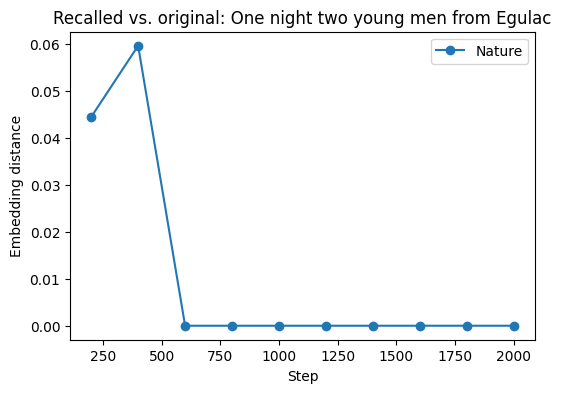

In [167]:
# Define the file path for the stored outputs and topics to analyze
file_path = f'/content/drive/MyDrive/colab_code/outputs2510/combined_results_dict_{prompt1}.pkl'
topics = ['Nature']  # Add more topics as needed

# Process stored results to calculate word differences
word_diff_results = process_stored_results(file_path)

# Plot new words count by epoch for each topic
plot_new_words(word_diff_results, topics, prompt1)


{0: 'Once upon a time in Egulac, two men from the Department of Agriculture, Forestry and Fisheries went down to the river to hunt seals and while they were there it became foggy and calm. Then they heard war-cries, and they thought: "Maybe this is a war-party". They escaped to the shore, and hid behind a log. Now canoes came up, and they heard the noise of paddles, and saw one canoe coming up to them. There were five men in the canoe, and they said:\n"What do you think? We wish to take you along. We are going up the river to make war on the people."\nOne of the young men said,"I have no arrows."\n"Arrows are in the canoe," they said.\n"I will not go along. I might be killed. My relatives do not know where I have gone. But you," he said, turning to the other, "may go with them."\nSo one of the young men went, but the other returned home.\nAnd the warriors went on up the river to a town on the other side of Kalama. The people came down to the water and they began to fight, and many were

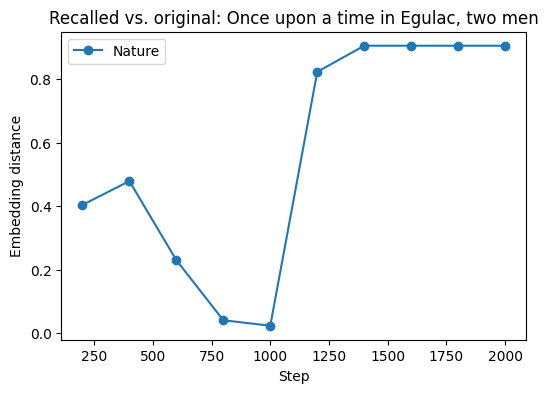

In [168]:
# Define the file path for the stored outputs and topics to analyze
file_path = f'/content/drive/MyDrive/colab_code/outputs2510/combined_results_dict_{prompt2}.pkl'
topics = ['Nature']  # Add more topics as needed

# Process stored results to calculate word differences
word_diff_results = process_stored_results(file_path)

# Plot new words count by epoch for each topic
plot_new_words(word_diff_results, topics, prompt2)


{0: 'The story of the battle of Egulac:\n"Meillionen" is the name of a farmhouse in the Cwm and of a small halt on the Welsh Highland Railway between Caernarfon and Porthmadog.\nForsinard Flows is a national nature reserve (NNR) covering much of the area surrounding Forsinard in the Highland council area of Scotland. It lies at the heart of the Flow Country, a large, rolling expanse of peatland and wetland area of Caithness and Sutherland that makes up almost 5% of the world\'s blanket bog. The reserve is managed by the Royal Society for the Protection of Birds (RSPB), and is designated a Category II protected area by the International Union for Conservation of Nature. Much of the NNR overlaps with the designated area of the Caithness and Sutherland Peatlands Special Protection Area and Special Area of Conservation.\n\nHabitat\nThe Flow Country is Europe\'s largest expanse of blanket bog, a unique type of habitat for many species. Blanket bogs form in cool, wet areas with acidic soils,

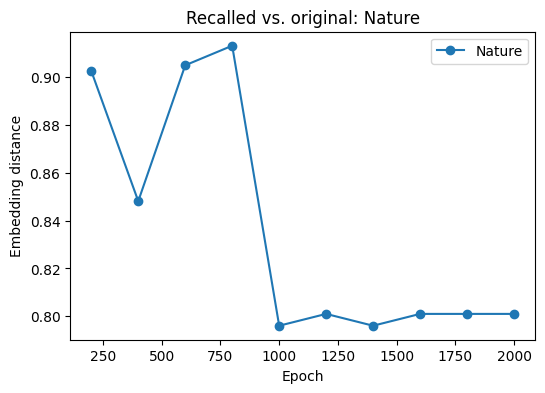

In [159]:
# Define the file path for the stored outputs and topics to analyze
file_path = f'/content/drive/MyDrive/colab_code/outputs2510/combined_results_dict_{prompt3}.pkl'
topics = ['Nature']  # Add more topics as needed

# Process stored results to calculate word differences
word_diff_results = process_stored_results(file_path)

# Plot new words count by epoch for each topic
plot_new_words(word_diff_results, topics)
